In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_size = 299
data_dir = "../input/brain-tumor-classification-mri/"
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

In [3]:
def load_images(directory, image_size):
    X = []
    y = []

    for label in labels:
        folderPath = os.path.join(directory, label)
        for filename in os.listdir(folderPath):
            img = cv2.imread(os.path.join(folderPath, filename))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

In [4]:
X, y = load_images(os.path.join(data_dir, "Training"), image_size)
X_test, y_test = load_images(os.path.join(data_dir, "Testing"), image_size)

In [5]:
X = np.concatenate((X, X_test), axis=0)
y = np.concatenate((y, y_test), axis=0)

In [6]:
X, y = shuffle(X, y, random_state=42)

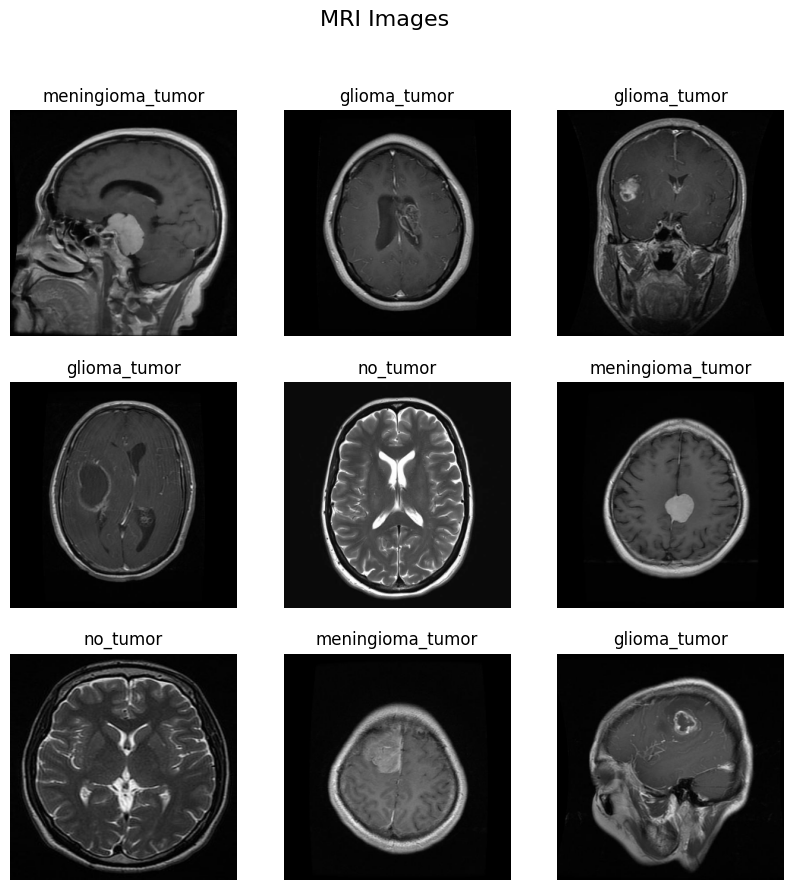

In [7]:
def visualize_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)

    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')

    plt.show()

visualize_images(X, y, 'MRI Images')

In [8]:
y = tf.keras.utils.to_categorical([labels.index(label) for label in y])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [12]:
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in xception_model.layers:
    layer.trainable = False

In [13]:
model = keras.Sequential([
    xception_model,
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(4, activation="softmax")
])

In [14]:
model.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [15]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50
91/91 [==============================] - 75s 752ms/step - loss: 6.5558 - accuracy: 0.5642 - val_loss: 0.8952 - val_accuracy: 0.7003
Epoch 2/50
91/91 [==============================] - 68s 747ms/step - loss: 1.0905 - accuracy: 0.6706 - val_loss: 0.7603 - val_accuracy: 0.7309
Epoch 3/50
91/91 [==============================] - 68s 746ms/step - loss: 0.8109 - accuracy: 0.7115 - val_loss: 0.6433 - val_accuracy: 0.7492
Epoch 4/50
91/91 [==============================] - 68s 748ms/step - loss: 0.7255 - accuracy: 0.7198 - val_loss: 0.5561 - val_accuracy: 0.7951
Epoch 5/50
91/91 [==============================] - 68s 746ms/step - loss: 0.7202 - accuracy: 0.7336 - val_loss: 0.5962 - val_accuracy: 0.7676
Epoch 6/50
91/91 [==============================] - 69s 759ms/step - loss: 0.6630 - accuracy: 0.7501 - val_loss: 0.5113 - val_accuracy: 0.7920
Epoch 7/50
91/91 [==============================] - 69s 755ms/step - loss: 0.6508 - accuracy: 0.7590 - val_loss: 0.5307 - val_accuracy: 0.8196

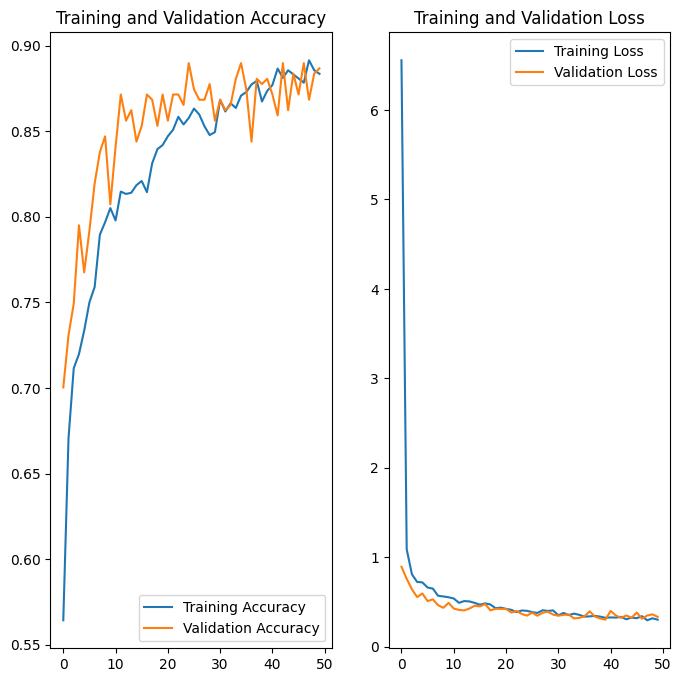

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model.evaluate(X_test,y_test)

11/11 [==============================] - 1s 128ms/step - loss: 0.3347 - accuracy: 0.8869


[0.3346724510192871, 0.8868501782417297]

11/11 [==============================] - 2s 132ms/step


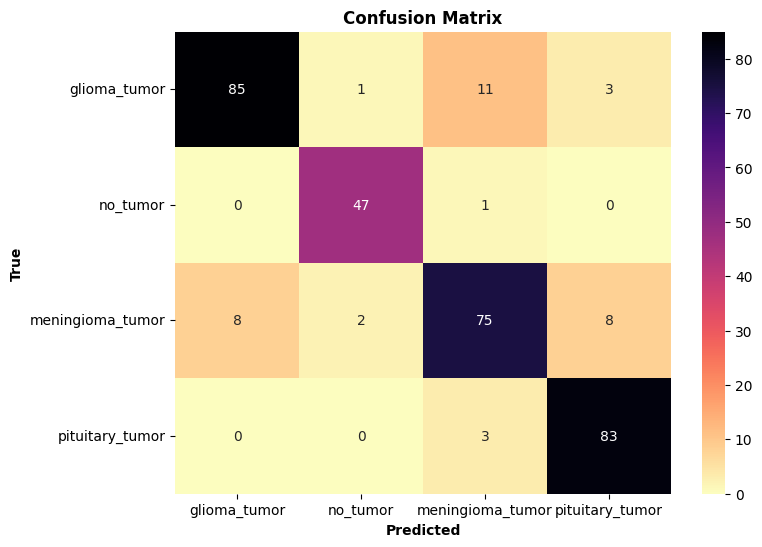

In [18]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

In [19]:
def preprocess_image(image_path, image_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_tumor_class(model, image_path, labels):
    image = preprocess_image(image_path, image_size)
    prediction = model.predict(image)
    predicted_class = labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return predicted_class, confidence

In [20]:
image_path = "/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor/image(103).jpg"
predicted_class, confidence = predict_tumor_class(model, image_path, labels)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 [==============================] - 0s 279ms/step
Predicted Class: no_tumor
Confidence: 99.53%


In [21]:
from keras.models import load_model

model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
